In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Cargar y explorar el dataset

Es fundamental explorar el dataset para entender la cantidad de datos, verificar el balance entre clases y anticipar si necesitaremos técnicas como balanceo o muestreo.

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
label
0    20019
1    19981
Name: count, dtype: int64


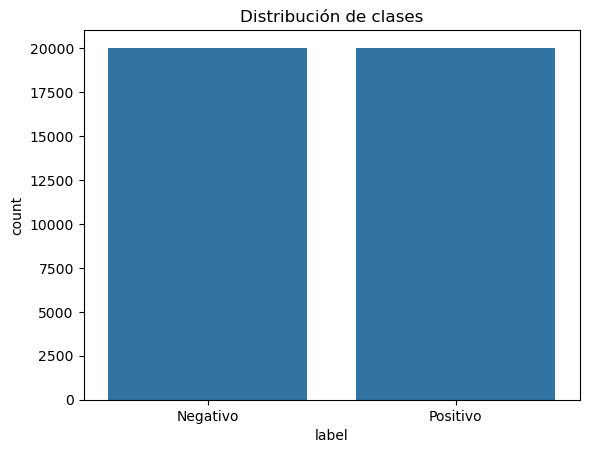

In [84]:
# Cargamos el dataset con las columnas 'text' y 'label'
df = pd.read_csv("movie.csv")

# Vista previa de las primeras filas
print(df.head())

# Verificamos la distribución de clases
print(df.label.value_counts())

# Visualizamos la distribución de clases
sns.countplot(x='label', data=df)
plt.title("Distribución de clases")
plt.xticks([0, 1], ['Negativo', 'Positivo'])
plt.show()


# Preprocesamiento del texto

El preprocesamiento asegura que el modelo trabaje con texto homogéneo y sin ruido, lo que mejora significativamente el rendimiento del modelo.

In [87]:
# Función para limpiar texto de caracteres innecesarios
def clean_text(text):
    text = str(text).lower()  # Pasar a minúsculas
    text = re.sub(r"<.*?>", "", text)  # Eliminar etiquetas HTML
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Eliminar puntuación
    text = re.sub(r"\d+", "", text)  # Eliminar números
    return text

# Aplicamos limpieza al texto
df['text_clean'] = df['text'].apply(clean_text)



# Tokenización y padding

Las redes neuronales no pueden procesar texto directamente. Se necesita convertir palabras a números (tokenización) y asegurar que todas las secuencias tengan igual tamaño (padding).

In [90]:
# Definimos hiperparámetros
MAX_WORDS = 10000  # Número máximo de palabras que se considerarán
MAX_LEN = 200      # Longitud máxima de cada secuencia

# Convertimos texto a secuencias numéricas
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_clean'])
sequences = tokenizer.texts_to_sequences(df['text_clean'])

# Rellenamos las secuencias para que tengan la misma longitud
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Variable objetivo
y = df['label'].values


# División de los datos en entrenamiento y prueba

Dividir los datos permite evaluar el rendimiento del modelo en datos no vistos y ajustar hiperparámetros sin sobreajustar.

In [93]:
# Dividimos los datos: 70% entrenamiento, 15% validación, 15% prueba
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Definición del modelo RNN (LSTM)

LSTM es una arquitectura especializada en datos secuenciales como texto. Captura dependencias de largo plazo, ideal para clasificación de sentimientos. Dropout ayuda a evitar sobreajuste.

In [96]:
# Dimensión de los vectores de embeddings
EMBEDDING_DIM = 100

# Arquitectura de la red neuronal
model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),  # Capa de representación de palabras
    LSTM(64),                      # Capa de memoria (RNN)
    Dropout(0.5),                  # Capa de regularización para evitar overfitting
    Dense(1, activation='sigmoid')  # Capa de salida binaria (positivo o negativo)
])

# Compilamos el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen del modelo
model.summary()



C:\Users\fvarg\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento

Entrenar con early stopping ayuda a evitar que el modelo sobreentrene. Además, usar un conjunto de validación permite ajustar hiperparámetros con seguridad.

In [99]:
# Detener el entrenamiento si no mejora la validación
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamos el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=2
)



Epoch 1/10
219/219 - 38s - 175ms/step - accuracy: 0.7650 - loss: 0.4740 - val_accuracy: 0.8670 - val_loss: 0.3238
Epoch 2/10
219/219 - 31s - 141ms/step - accuracy: 0.8934 - loss: 0.2684 - val_accuracy: 0.8693 - val_loss: 0.3150
Epoch 3/10
219/219 - 29s - 134ms/step - accuracy: 0.9166 - loss: 0.2185 - val_accuracy: 0.8635 - val_loss: 0.3666
Epoch 4/10
219/219 - 29s - 130ms/step - accuracy: 0.9401 - loss: 0.1655 - val_accuracy: 0.8570 - val_loss: 0.4089
Epoch 5/10
219/219 - 31s - 140ms/step - accuracy: 0.9514 - loss: 0.1364 - val_accuracy: 0.8612 - val_loss: 0.3999


# Evaluación

Evaluar con datos que el modelo nunca ha visto permite obtener una medida real de su rendimiento.

In [102]:
# Evaluamos en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Precisión en test: {accuracy:.4f}")

# Realizamos predicciones
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32")

# Reporte de métricas
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))



188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8736 - loss: 0.3021
Precisión en test: 0.8712
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
              precision    recall  f1-score   support

    Negativo       0.87      0.86      0.87      2939
    Positivo       0.87      0.88      0.87      3061

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



# Matriz de confusión y gráficas de rendimiento

Estas gráficas ayudan a visualizar el aprendizaje del modelo y a detectar posibles problemas como overfitting o underfitting.

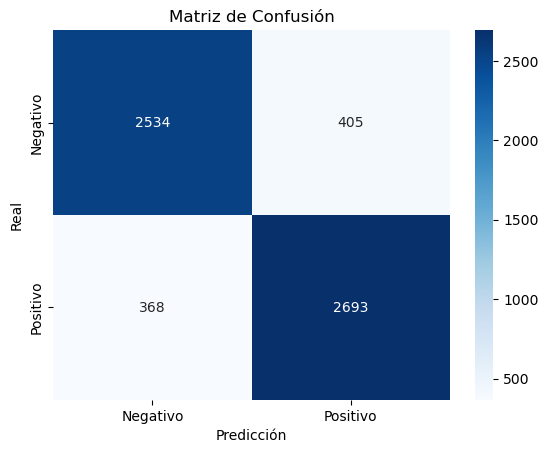

In [105]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()


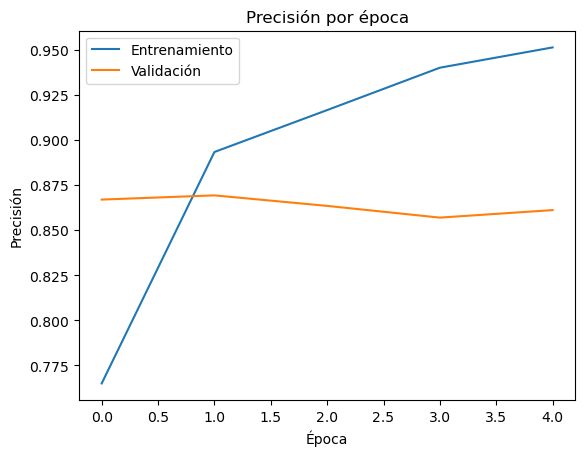

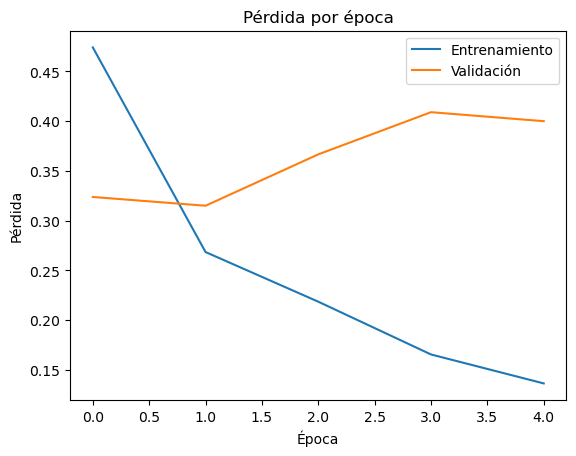

In [106]:
# Precisión por época
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión por época')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida por época
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
